In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering

/home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering


In [2]:
import pandas as pd
from popscorer.fitness.ev_onehot import EVOnehotFitness

train = False
from popgen.utils.utils import parse_config

config = parse_config('notebooks/first_round/config/predictor_config.yaml')['activity']['ev_onehot']


def get_raw_activity_score(aa_seqs):
    score, raw_score = EVOnehotFitness(config)(aa_seqs)
    return raw_score

subtilisin_BPN = 'AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAGGASMVPSETNPFQDNNSHGTHVAGTVAALNNSIGVLGVAPSASLYAVKVLGADGSGQYSWIINGIEWAIANNMDVINMSLGGPSGSAAL' \
    'KAAVDKAVASGVVVVAAAGNEGTSGSSSTVGYPGKYPSVIAVGAVDSSNQRASFSSVGPELDVMAPGVSIQSTLPGNKYGAYNGTSMASPHVAGAAALILSKHPNWTNTQVRSSLENTTTKLGDSFYYGKGLINVQAAAQ'

def get_mutations(aa_seq):
    muts = []
    for i in range(len(subtilisin_BPN)):
        if subtilisin_BPN[i] != aa_seq[i]:
            muts.append(f"{subtilisin_BPN[i]}{i+1}{aa_seq[i]}")
    return '/'.join(muts)


# Compare model-generated variants with random variants

## Load model-generated variants
### Calculate `mutations` and `n_muts`

In [4]:
train = False

data_path = 'data/round1/dry-lab/results/all_step_aa_seqs.csv'

if train:
    df_data = pd.read_csv(data_path)
    display(len(df_data), df_data.columns)

    df_data['mutations'] = [get_mutations(aa_seq) for aa_seq in df_data.aa_seqs]

    n_muts = []
    for muts in df_data.mutations:
        if '/' in muts:
            n_muts.append(len(muts.split('/')))
        elif muts.strip() != '': #if muts is not None:
            n_muts.append(1)
        else:
            n_muts.append(0)
    df_data['n_muts'] = n_muts

    df_data['pred_fitness'] = get_raw_activity_score(df_data.aa_seqs)
    display(df_data.n_muts.min(), df_data.n_muts.max())
    df_data.to_csv(data_path+'_pred.csv', index=False) 
else:
    df_data = pd.read_csv(data_path+'_pred.csv')

In [4]:
df_data.n_muts.min(), df_data.n_muts.max()

(0, 11)

## Random variants

In [6]:
import random

nat_AAs = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

pos_aa_candidates = {2: ['K', 'L', 'Q'],
                         3: ['L', 'A', 'T', 'Y', 'C', 'V', 'S'],
                         24: ['C', 'P', 'S'],
                         43: ['R', 'D', 'S', 'E', 'N', 'K'],
                         50: ['S', 'F', 'V', 'M'],
                         76: ['S', 'D', 'N'],
                         98: ['R', 'D', 'K', 'L', 'S', 'T', 'E', 'G', 'N', 'C', 'Q', 'V', 'M', 'A'],
                         107: ['A', 'T', 'G', 'V', 'M', 'I'],
                         124: ['C', 'I', 'L', 'M'],
                         125: ['A', 'G', 'S'],
                         126: ['F', 'A', 'I', 'G', 'C', 'V', 'L'],
                         131: ['H', 'R', 'F', 'D', 'L', 'W', 'S', 'A', 'T', 'C', 'Q', 'M', 'G'],
                         152: ['C', 'S', 'P', 'A'],
                         169: ['A', 'G'],
                         204: ['S', 'D', 'F', 'T'],
                         206: ['K', 'L', 'P', 'E', 'C', 'Q'],
                         209: ['H', 'F', 'C', 'L'],
                         213: ['R', 'A', 'E', 'Y', 'V', 'K'],
                         217: ['D', 'K', 'L', 'A', 'G', 'C', 'V', 'M', 'Y'],
                         218: ['H', 'D', 'S', 'A', 'T', 'N'],
                         222: ['R', 'F', 'P', 'S', 'Y', 'D', 'G', 'N', 'C', 'Q', 'V', 'K', 'E', 'H', 'L', 'A', 'I', 'T', 'W', 'M'],
                         223: ['S', 'G', 'A'],
                         224: ['C', 'S', 'A'],
                         256: ['R', 'G', 'N', 'Y', 'K'],
                         271: ['E', 'A', 'Q']}

def gen_a_random_variant(n_muts, pos2opt=None):
    
    positions = random.sample(range(1, len(subtilisin_BPN)+1), n_muts) if not pos2opt \
        else random.sample(list(pos2opt.keys()), n_muts)
    
    mutant_seq = list(subtilisin_BPN)
    mutations = []
    
    for pos in sorted(positions):
        ref = subtilisin_BPN[pos-1]
        mut = random.choice(list(set(nat_AAs) - set([ref]))) if not pos2opt \
            else random.choice(list(set(pos2opt[pos]) - set([ref])))
        mutant_seq[pos-1] = mut
        mutations.append(f"{ref}{int(pos)}{mut}")
        
    return ''.join(mutant_seq), '/'.join(mutations)

def gen_random_variants(n_mutant, n_muts, pos2opt=None):
    mutant_seqs = []
    mutants = []
    for i in range(n_mutant):
        mutant_seq, mutant = gen_a_random_variant(n_muts, pos2opt=pos2opt)
        
        mutant_seqs.append(mutant_seq)
        mutants.append(mutant)
    return mutant_seqs, mutants

# gen_random_variants(3, 4, pos2opt=pos_aa_candidates)

In [7]:
def gen_random_variants_batch(n_mutants=1000, max_n_muts=12, pos2opt=None):
    n_muts = []
    mutant_seqs = []
    mutants = []

    for n_mut in range(1, max_n_muts+1):
        n_mut_seqs, n_mut_mutants = gen_random_variants(n_mutants, n_mut, pos2opt=pos2opt)
        n_muts = n_muts + [n_mut]*n_mutants
        mutant_seqs = mutant_seqs + n_mut_seqs
        mutants = mutants + n_mut_mutants

    df_random_mutants = pd.DataFrame({'n_muts': n_muts, 'mutations': mutants, 'seq': mutant_seqs})
    return df_random_mutants

In [8]:
train = False
if train:
    # Sample 1000 mutants for each n_mut in range of 1-12
    
    # Random mutants in whole sequence
    df_random_mutants_hs = gen_random_variants_batch(n_mutants=1000, max_n_muts=12, pos2opt=None)
    df_random_mutants_hs['pred_fitness'] = get_raw_activity_score(df_random_mutants_hs.seq)
    
    # Random mutants in optimization positions
    df_random_mutants_opt = gen_random_variants_batch(n_mutants=1000, max_n_muts=12, pos2opt=pos_aa_candidates)
    df_random_mutants_opt['pred_fitness'] = get_raw_activity_score(df_random_mutants_opt.seq)
    
    df_random_mutants_hs.to_csv('data/round1/dry-lab/results/random_baseline_whole_seq.csv')
    df_random_mutants_opt.to_csv('data/round1/dry-lab/results/random_baseline_opt.csv')

else:
    df_random_mutants_hs = pd.read_csv('data/round1/dry-lab/results/random_baseline_whole_seq.csv', index_col=[0])
    df_random_mutants_opt = pd.read_csv('data/round1/dry-lab/results/random_baseline_opt.csv', index_col=[0])

## Draw comparison figures

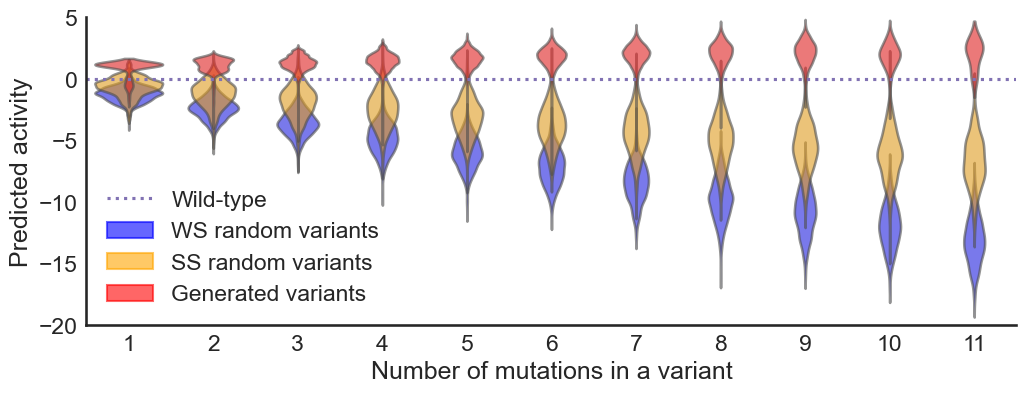

In [9]:
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np
from utils import plot_style_utils

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax(figsize=(12, 4))
plot_style_utils.prettify_ax(ax)

ax = sns.violinplot(data=df_random_mutants_hs[(df_random_mutants_hs.n_muts > 0) & (df_random_mutants_hs.n_muts<12)], x="n_muts", y="pred_fitness", color='blue', inner=None)
ax = sns.violinplot(data=df_random_mutants_opt[(df_random_mutants_opt.n_muts>0) & (df_random_mutants_opt.n_muts<12)], x="n_muts", y="pred_fitness", color='orange', inner=None)
ax = sns.violinplot(data=df_data[(df_data.n_muts>0) & (df_data.n_muts<12)], x="n_muts", y="pred_fitness", color='red', inner=None)

for villion in ax.collections:
    villion.set_alpha(.6)

ax.set_xlabel('Number of mutations in a variant')
ax.set_ylabel('Predicted activity')
ax.set_ylim(-20, 5)

line_patch = ax.axhline(y=-0.007327, color='m', linestyle='dotted', label='Wild-type') 

blue_patch = mpatches.Patch(color='blue', label='WS random variants', alpha=.6)
orange_patch = mpatches.Patch(color='orange', label='SS random variants', alpha=.6)
red_patch = mpatches.Patch(color='red', label='Generated variants', alpha=.6)

ax.legend(loc='lower left', handles=[line_patch, blue_patch, orange_patch, red_patch], frameon=False)

plot_style_utils.save_for_pub(fig=fig, path='figures/round1/eval_variant_random_vs_designed_violin')